In [8]:
import pyarrow as pa
import pyarrow.dataset as ds
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import warnings
import numpy as np
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')


warnings.filterwarnings('ignore')

file_name = "./bulk.airflow.downloaded_1min.parquet.ohlcv.futures.v7.ccxt.binance.v1_0_0"
schema = None
partitioning = ds.partitioning(schema, flavor="hive")
dataset = pq.ParquetDataset(
    # Replace URI with path.
    file_name,
    #filesystem=filesystem,
    #filters=filters,
    partitioning=partitioning,
    use_legacy_dataset=False,
)
# To read also the index we need to use `read_pandas()`, instead of
# `read_table()`.
# See https://arrow.apache.org/docs/python/parquet.html#reading-and-writing-single-files.
columns = None
table = dataset.read_pandas(columns=columns)
df = table.to_pandas()




In [9]:
bitcoin_2022_df = df.loc[(df['currency_pair'] == 'BTC_USDT') & (df['year'] == 2022)]

In [10]:
bitcoin_2022_df_cpy = bitcoin_2022_df.copy()
bitcoin_2022_df_cpy =  bitcoin_2022_df_cpy.sort_index()
bitcoin_2022_df_cpy.rename(columns= {'volume' : 'y'}, inplace=True)
bitcoin_2022_df_cpy = bitcoin_2022_df_cpy.drop_duplicates(subset = 'timestamp')
bitcoin_2022_df_cpy.drop(['timestamp'], axis = 1, inplace = True)
bitcoin_2022_df_cpy = bitcoin_2022_df_cpy.asfreq('T')
bitcoin_2022_df_cpy['y'] = bitcoin_2022_df_cpy['y'].rolling(window = 50).std()

In [15]:
k = 5
for i in range(1, k+1):
    column_name = f'x_{i}'
    bitcoin_2022_df_cpy[column_name] = bitcoin_2022_df_cpy['y'].shift(i)
    
cols = ['y'] + [f'x_{i}' for i in range(1, k+1)]
bitcoin_2022_df_cpy = bitcoin_2022_df_cpy.dropna()
bitcoin_2022_df_cpy = bitcoin_2022_df_cpy[cols]
bitcoin_2022_df_cpy = bitcoin_2022_df_cpy.sort_index().last("3M")

In [16]:
from scipy import stats

In [17]:
bitcoin_2022_df_cpy['y'].describe()

count    132480.000000
mean        341.859672
std         479.035000
min          13.418188
25%          97.346519
50%         175.862411
75%         377.159713
max        5929.112707
Name: y, dtype: float64

In [18]:
bitcoin_2022_df_cpy = bitcoin_2022_df_cpy[bitcoin_2022_df_cpy['y'] <= 500]


Train dates : 2022-10-01 00:00:00+00:00 --- 2022-12-24 10:32:00+00:00  (n=98416)
Test dates  : 2022-12-24 10:33:00+00:00 --- 2022-12-31 23:59:00+00:00  (n=10080)


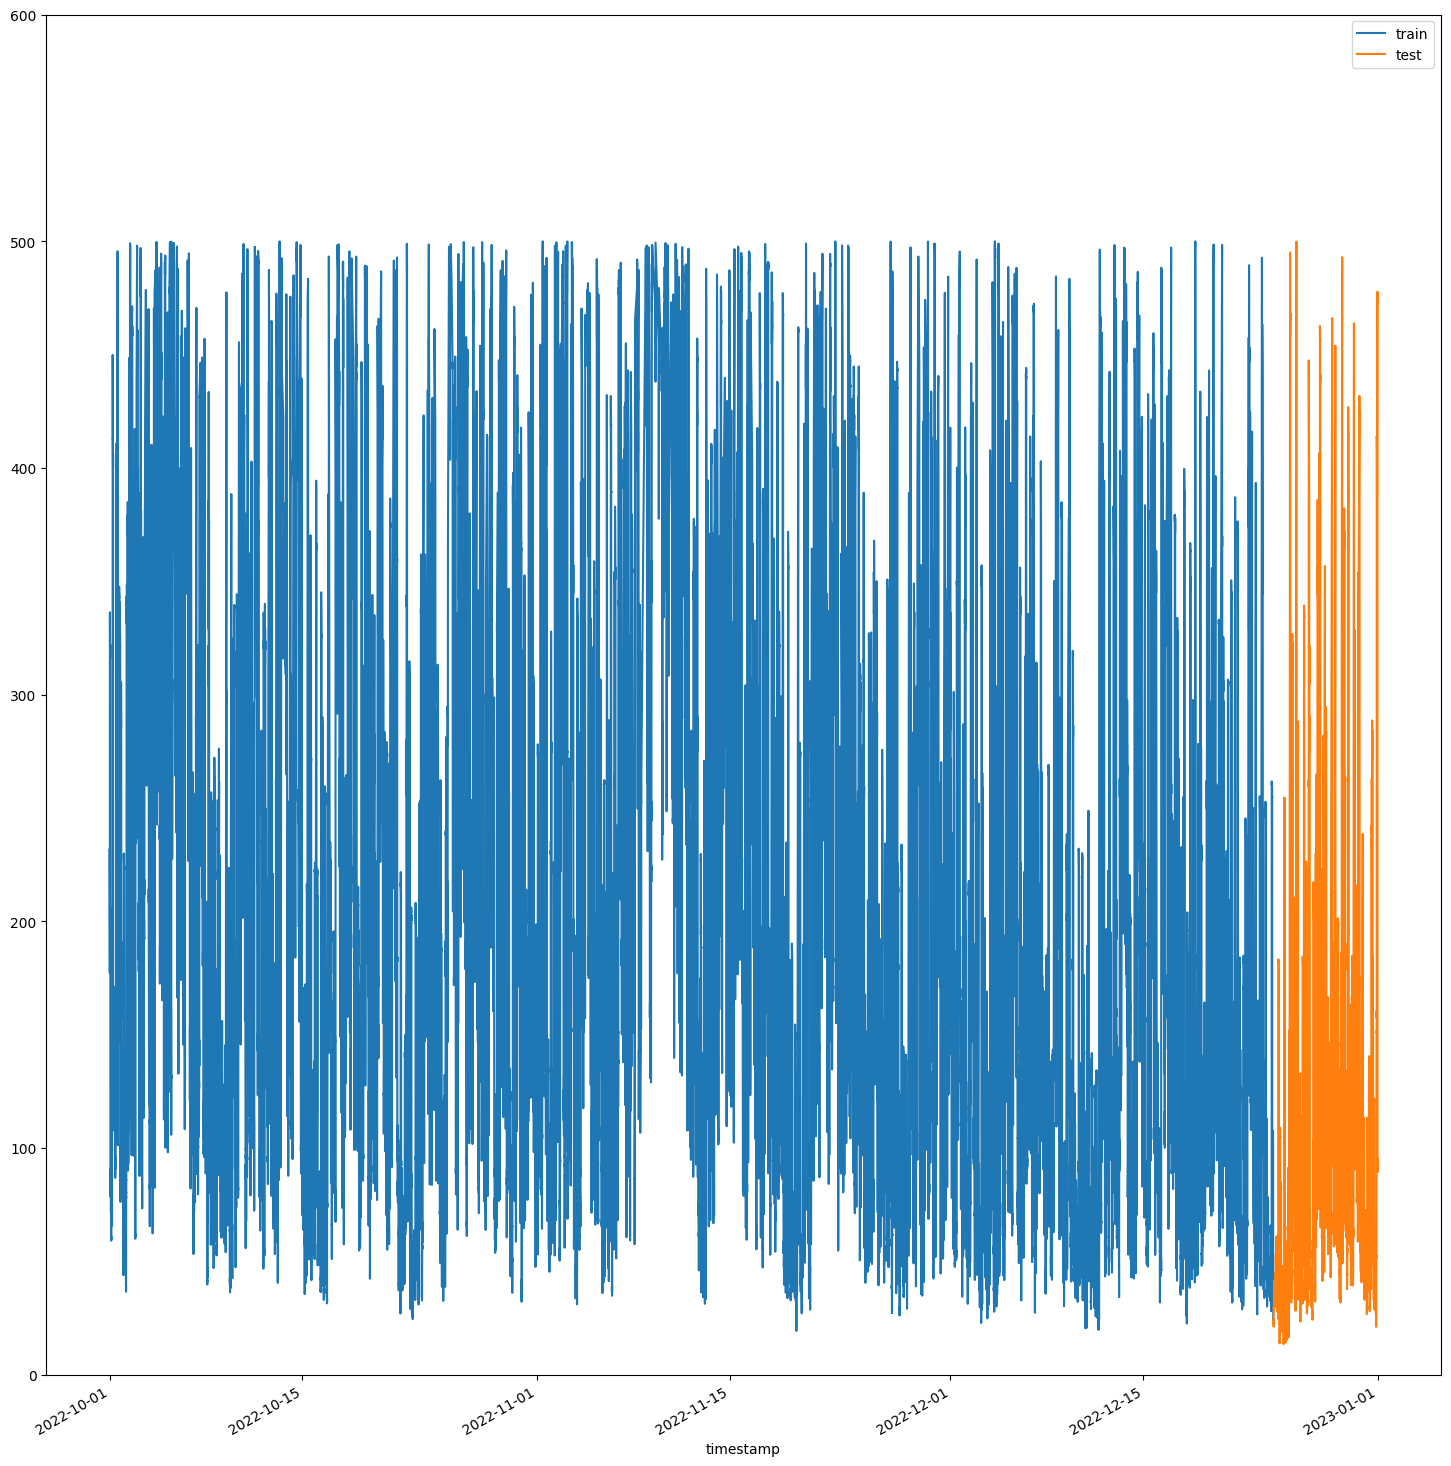

In [23]:
steps = 10080
data_train = bitcoin_2022_df_cpy[:-steps]
data_test  = bitcoin_2022_df_cpy[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(18, 20))
ax.set_ylim(0,600)
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

In [24]:
import statsmodels.api as sm

# Add intercept to X values
data_train = sm.add_constant(data_train)
data_test = sm.add_constant(data_test)

# Fit OLS model on training data
model = sm.OLS(data_train['y'], data_train[['const', 'x_1', 'x_2', 'x_3', 'x_4']])
results = model.fit()

# Predict using test data and print summary statistics
predictions = results.predict(data_test[['const', 'x_1', 'x_2', 'x_3', 'x_4']])
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                 5.042e+05
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        18:51:38   Log-Likelihood:            -4.5694e+05
No. Observations:               98416   AIC:                         9.139e+05
Df Residuals:                   98411   BIC:                         9.139e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.9687      0.147     54.169      0.0

In [25]:
predictions.nunique()

10080

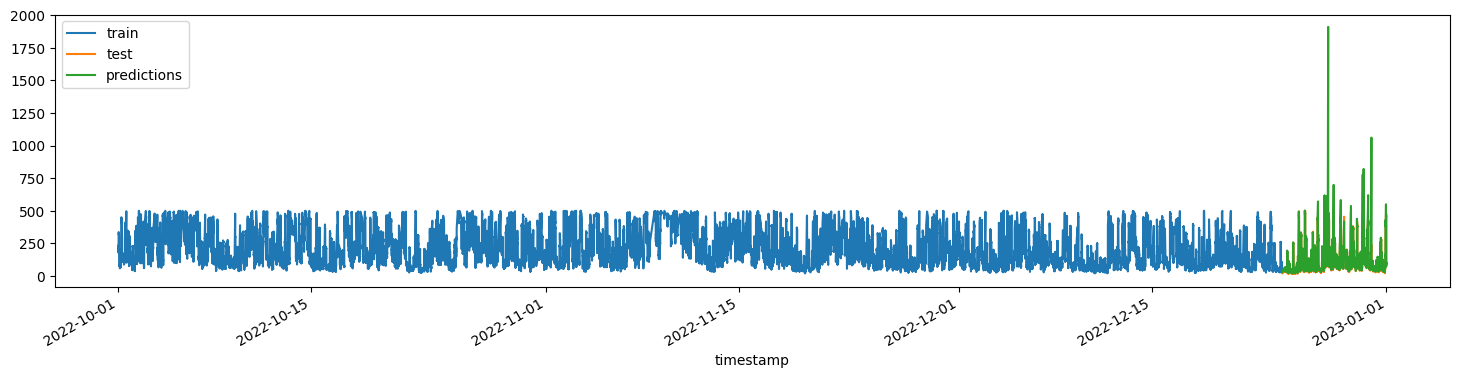

In [26]:
fig, ax = plt.subplots(figsize=(18, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [28]:
mean_squared_error(data_test['y'],predictions)

566.7297386150212